<a href="https://colab.research.google.com/github/gomes-lab/course-cs2770-2024sp/blob/main/statistical_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning for Species Distribution Modeling

In this notebook we'll test using logistic regression and a random forest classifier to model the breeding season distribution of a threatened species of bird in the North East US.

<img align="right" width="360" height="250" src="https://github.com/gomes-lab/course-cs2770-2021sp/blob/main/Bobolink.png?raw=true">

**Background:** The Bobolink is one of the most striking passerines in North America, where males have both a distinct appearance and song. Their diet consists of insects, seeds, and grains. Bobolinks build their nests on the ground in small depressions out of dead grasses and weeds.

Although still fairly common across the US, Bobolink numbers are estimated to have decreased across North America over the past several decades. Declines can be attributed to farm abandonment and modern hay practices of more frequent and early cutting. In New York, the main cause of nest failure is cutting hay during the nesting season. In addition, Bobolinks are persecuted as agricultural pests in their wintering range.

In [1]:
"""
Run this cell to import the necessary packages
"""
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import urllib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
plt.rcParams.update({'font.size': 14})
import warnings
warnings.filterwarnings('ignore')

## Data

We'll be using data from eBird from the breeding season (May 15 - June 15) over the years of 2004-2014. The data has already been split into training, validation, and test sets.

Each row of the dataset contains information from one eBird checklist, where the column `y` indicates whether a Bobolink was observed. The other columns are the features we will use to fit the model. The first six column contain information about the survey, such as the time of day the survey started (`TIME`), number of hours spent (`EFFORT_HRS`), and the distance traveled during the survey (`EFFORT_DISTANCE_KM`). The next 14 columns contain environmental variables such as elevation and the proportion of different land cover types in the 3km x 3km neighborhood centered on the survey location.

**Question:** Based on your knowledge of the eBird problem and the background on the Bobolink above, give one survey feature and one environmental variable that you think will be predictive of a Bobolin occuring, brielfy justifying your answer.

**Question:** Run the cells below to produce a map of eBird surveys, where observations with a Bobolink are colored blue and surveys without a Bobolink are grey. Include the map in your writeup and briefly describe both the distribution of eBird surveys and the distribution of Bobolink.

In [18]:
"""
Run this cell to load the data
"""
# train_data - subset of the data used to train, or fit the the predictive models
# test_data - subset of the data used to indepently assess the model
# map_data - this data set includes all of the predictors evaluated across a regular grid of locations that covers the study area.
url_train='https://raw.githubusercontent.com/gomes-lab/course-cs2770-2024sp/main/data/Bobolink_training.data.csv'
url_test= 'https://raw.githubusercontent.com/gomes-lab/course-cs2770-2024sp/main/data/Bobolink_testing.data.csv'
url_map='https://raw.githubusercontent.com/gomes-lab/course-cs2770-2024sp/main/data/Bobolink_map.data.csv'
train_data= pd.read_csv(url_train)
test_data=pd.read_csv(url_test)
map_data=pd.read_csv(url_map)

# Look at the data structure
train_data.head() #print out the first few lines of the csv file

,LATITUDE,LONGITUDE,YEAR,TIME,EFFORT_HRS,EFFORT_DISTANCE_KM,Elevation,Water,Evergreen_needle,Evergreen_broad,...,Mixed_forest,Closed_shrubland,Open_shrubland,Woody_savannas,Savannas,Grasslands,Croplands,Urban_Built,Barren,y
0,35.272655,-76.612885,2004,7.5,1.250,0.000,9,2.7778,44.4444,0.0,...,52.7778,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0
1,35.290469,-75.513153,2004,10.0,1.500,1.609,0,100.0000,0.0000,0.0,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0
2,35.665910,-75.479900,2004,15.0,1.500,0.000,11,77.5862,1.7241,0.0,...,1.7241,0.0,0.0,0.0000,0.0,0.0,1.7241,0.0000,17.2414,0
3,35.864075,-75.862010,2004,9.0,1.500,0.000,13,0.0000,0.0000,0.0,...,63.8889,0.0,0.0,30.5556,0.0,0.0,5.5556,0.0000,0.0000,0
4,35.954400,-78.943400,2004,7.5,0.083,0.000,112,0.0000,0.0000,0.0,...,11.1111,0.0,0.0,25.0000,0.0,0.0,2.7778,61.1111,0.0000,0


(-79.9990082, -70.0004995, 35.0016676, 44.9990994)


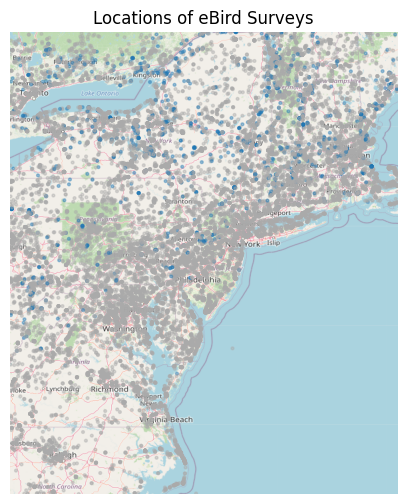

In [14]:
"""
Run this cell to plot the locations of data
"""
#First find the boundaries of the map
BBox = ((train_data.LONGITUDE.min(),   train_data.LONGITUDE.max(),
         train_data.LATITUDE.min(), train_data.LATITUDE.max()))
print(BBox)

# We exported a map within the bounding box from OpenStreetMap
# Load the map
url = 'https://github.com/gomes-lab/course-cs2770-2021sp/blob/main/NY_map_small.png?raw=true'
ny_map = np.array(PIL.Image.open(urllib.request.urlopen(url)))

# Set the colors of the dots
set_color=lambda x : '#1f77b4' if (x==1) else '#aaaaaa'
color=[set_color(x) for x in train_data.y]
fig, ax = plt.subplots(figsize = (5,6))
plt.rcParams.update({'font.size': 10})

# Plot the map under the scatter points
ax.imshow(ny_map,extent = BBox,aspect='auto')
ax.scatter(train_data.LONGITUDE, train_data.LATITUDE, c=color, alpha=0.4, s=4)
ax.set_title('Locations of eBird Surveys')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.axis('off')
plt.show()

## Models

Next we'll fit both logistic regression and random forest models to predict the distribtion of Bobolinks during the mating season and compare their performance.

**Question:** Run the cell below to fit a logistic regression model. The `coef` column of the lower table shows the coefficient associated with each feature in the model, where the `Intercept` value is a constant not associated with a variable. What three features have the largest magnitude coefficients? Briefly explain if you think the high value of these coefficients as well as their sign make sense given your knowledge of eBird and the background on Bobolinks.

**Question:** Run the next two cells to fit the random forest model and print metrics associated with both models. For MSE (mean-squared error) a smaller value is better while for the log-loss and AUC a higher value is better. Which model performs best for each metric? Do the metrics agree?

In [4]:
"""
Run this cell to fit the data to a logistic regression model
"""
d=smf.glm(formula = "y ~ Elevation + Croplands + Deciduous_broad + Grasslands + Mixed_forest + EFFORT_HRS + EFFORT_DISTANCE_KM + TIME + YEAR",
               family=sm.families.Binomial(),
               data=train_data).fit()
print(d.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18218
Model:                            GLM   Df Residuals:                    18208
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3809.0
Date:                Wed, 01 May 2024   Deviance:                       7617.9
Time:                        23:15:29   Pearson chi2:                 1.77e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03774
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -76.6315     25

In [5]:
"""
Run this cell to fit the data to a random forest model
"""
#n_jobs is the number of jobs to run in parallel
rf = RandomForestRegressor(n_estimators=100, n_jobs=8)
#fit the data; remember to remove the "y" column from training data
rf.fit(train_data[train_data.columns[0:21]],train_data.y)


RandomForestRegressor(n_jobs=8)

In [6]:
"""
Run this cell to assess the performance of the two models
"""
#ground truth
yyy=np.array(test_data.y)
#prediction of the two models
test_pred=d.predict(test_data)
test_pred2=rf.predict(test_data[train_data.columns[0:21]])

print('MSE of logistic regression model: {:.3f}'.format(np.mean((yyy-test_pred)**2)))
print('MSE of random forest model: {:.3f} \n'.format(np.mean((yyy-test_pred2)**2)))

# Add/subtract a small values from ones/zeros to avoid errors in computation
eps = 1e-5
test_pred = np.where(test_pred == 0 , eps, test_pred)
test_pred = np.where(test_pred == 1 , 1 - eps, test_pred)
test_pred2 = np.where(test_pred2 == 0 , eps, test_pred2)
test_pred2 = np.where(test_pred2 == 1 , 1 - eps, test_pred2)
print('Log-loss of logistic regression model: {:.3f}'.format(np.sum(yyy*np.log(test_pred) + (1-yyy)*np.log(1-test_pred))))
print('Log-loss of random forest model: {:.3f}\n'.format(np.sum(yyy*np.log(test_pred2) + (1-yyy)*np.log(1-test_pred2))))
print('AUC score of logistic regression model: {:.3f}'.format(roc_auc_score(test_data.y,test_pred)))
print('AUC score of random forest model: {:.3f}'.format(roc_auc_score(test_data.y,test_pred2)))

MSE of logistic regression model: 0.053
MSE of random forest model: 0.042 

Log-loss of logistic regression model: -3726.588
Log-loss of random forest model: -3048.814

AUC score of logistic regression model: 0.740
AUC score of random forest model: 0.881


## Species Distribution Map

The code below produces three plots: observations of Bobolink from the eBird data (left), the random forest model's predictions on the same locations as the eBird observations (center), and the random forest model's predictions for a dense grid of points.

**Question:** In your opinion, do the model's predictions for the survey locations looks similar to the eBird observations? Briefly justify your answer.

**Question:** Why were we able to make predictions for locations without eBird observations? What is one advantage of using a species distribution model instead of just the raw observations?

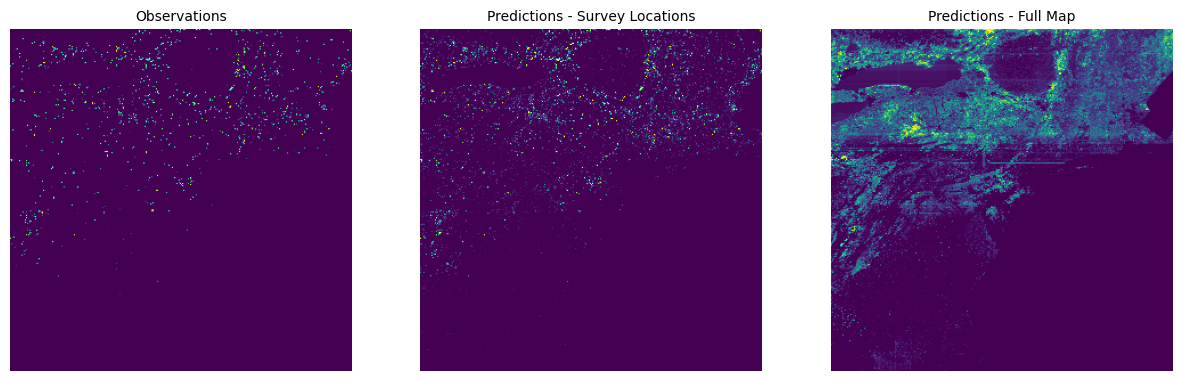

In [13]:
"""
Run this cell to plot an occurrence map for Bobolink
"""
# set these variables to constant values to remove variation in observation process
map_data['EFFORT_HRS'] = 1
map_data['EFFORT_DISTANCE_KM'] = 1
map_data['TIME'] = 7
map_data['YEAR'] = 2014

# make sure the sequence of the columns is the same as train_data
map_data = map_data[train_data.columns[0:21]]
map_data['PRED'] = rf.predict(map_data)

# Create the prediction array
n = 300
lat_bins = np.arange(map_data.LATITUDE.min(), map_data.LATITUDE.max(), \
                     (map_data.LATITUDE.max() - map_data.LATITUDE.min())/n)
lon_bins = np.arange(map_data.LONGITUDE.min(), map_data.LONGITUDE.max(), \
                     (map_data.LONGITUDE.max() - map_data.LONGITUDE.min())/n)

map_data['LAT_BIN'] = map_data['LATITUDE'].apply(lambda x: sum(lat_bins - x > 0) - 1)
map_data['LON_BIN'] = map_data['LONGITUDE'].apply(lambda x: n - sum(lon_bins - x > 0) - 1)

map_table = pd.pivot_table(map_data, columns='LON_BIN', index='LAT_BIN', values='PRED', aggfunc='mean').fillna(0)

# Create the observation array
obs_data = pd.concat([train_data, test_data])
obs_data['PRED'] = rf.predict(obs_data[obs_data.columns[0:21]])
lat_bins = np.arange(obs_data.LATITUDE.min(), obs_data.LATITUDE.max(), \
                     (obs_data.LATITUDE.max() - obs_data.LATITUDE.min())/n)
lon_bins = np.arange(obs_data.LONGITUDE.min(), obs_data.LONGITUDE.max(), \
                     (obs_data.LONGITUDE.max() - obs_data.LONGITUDE.min())/n)

obs_data['LAT_BIN'] = obs_data['LATITUDE'].apply(lambda x: sum(lat_bins - x > 0) - 1)
obs_data['LON_BIN'] = obs_data['LONGITUDE'].apply(lambda x: n - sum(lon_bins - x > 0) - 1)

obs_table = pd.pivot_table(obs_data, columns='LON_BIN', index='LAT_BIN', values='y', aggfunc='mean').fillna(0)
pred_table = pd.pivot_table(obs_data, columns='LON_BIN', index='LAT_BIN', values='PRED', aggfunc='mean').fillna(0)


# Plot observations
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(obs_table, cmap='viridis', vmin=0, vmax=1)
plt.title('Observations', size=10)
plt.axis('off')

# Plot survey predictions
plt.subplot(1,3,2)
plt.imshow(pred_table, cmap='viridis', vmin=0, vmax=0.6)
plt.title('Predictions - Survey Locations', size=10)
plt.axis('off')

# Plot dense grid locations
plt.subplot(1,3,3)
plt.imshow(map_table, cmap='viridis', vmin=0, vmax=0.6)
plt.title('Predictions - Full Map', size=10)
plt.axis('off')

plt.show()